In [1]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch
from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import pandas as pd
import difflib

import sys
sys.path.append('../AJA')
import AJA as aja

/Users/alicegorge/INF554/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [78]:
from sklearn.preprocessing import StandardScaler

def compter_mots(phrase):
    mots = phrase.split()  # Divisez la phrase en mots en utilisant les espaces comme délimiteurs
    return len(mots)

def calculate_similarity(text, neighbors, df):
    max_similarity = 0.0
    if isinstance(neighbors, list):
        for neighbor in neighbors:
            if neighbor != []:
                if isinstance(neighbor, int):
                    neighbor_index = neighbor
                else:
                    neighbor_index = neighbor[0]
                neighbor_text = df.iloc[neighbor_index]['text']
                matcher = difflib.SequenceMatcher(None, text.split(), neighbor_text.split())
                similarity = matcher.ratio()
                max_similarity = max(max_similarity, similarity)
    elif isinstance(neighbors, int):
        # Handle the case where 'neighbors' is an integer directly
        neighbor_index = neighbors
        neighbor_text = df.iloc[neighbor_index]['text']
        matcher = difflib.SequenceMatcher(None, text.split(), neighbor_text.split())
        max_similarity = matcher.ratio()
    return max_similarity



def f(df_nodes, df_edges):

    df = df_nodes.copy()
    
    # sentence length normalized
    df['sentence_length'] = df['text'].apply(lambda s: len(s.split()))
    scaler = StandardScaler()
    df['sentence_length'] = scaler.fit_transform(df['sentence_length'].values.reshape(-1, 1))

    # speaker hot-one encoding
    one_hot_encoded = pd.get_dummies(df['speaker_int'], prefix='speaker', dtype='int')
    df = pd.concat([df, one_hot_encoded], axis=1)
    
    #df['nb_interrogations'] = df['text'].apply(lambda x: x.count('?'))
    df['nb_occurences'] = df['text'].apply(lambda x: sum(x.split().count(mot) for mot in ['uh', 'um', 'okay', '<', 'ah', 'oh']))
    df['nb_occurences'] = scaler.fit_transform(df['nb_occurences'].values.reshape(-1, 1))

    #df['nb_words_more_5'] = df['text'].apply(lambda x: sum(len(mot) > 5 and mot.lower() != '<vocalsound>' for mot in x.split()))
    
    """
    # Calcul de la colonne 'neighb'
    df_edges_grouped = df_edges.groupby(['transcription', 'start'])['end'].apply(list).reset_index()
    df = pd.merge(df, df_edges_grouped, how='left', left_on=['transcription', 'line'], right_on=['transcription', 'start'])
    df = df.rename(columns={'end': 'neighb'})

    # Calcul de la colonne 'similarities'
    df['similarities'] = df.apply(lambda row: calculate_similarity(row['text'], row['neighb'],df), axis=1)
    """
    df = df.drop(['text', 'speaker_int', 'speaker_text'], axis=1)

    #df = df.drop(['text', 'speaker_int', 'speaker_text', 'start', 'neighb'], axis=1)
    print(df)
    return df

def g(df):
    new_df = pd.DataFrame({
        'transcription': df['transcription'],
        'start': df['end'],
        'end': df['start'],
        'type_int': 16 + df['type_int'],
        'type_text': df['type_text'] + "_reverse"
    })
    result_df = pd.concat([df, new_df], ignore_index=True)
    return result_df


In [79]:
train_graphs, validation_graphs, test_graphs = aja.get_graphs(f, g, 0.3)

      transcription  line  label    bert_0    bert_1    bert_2    bert_3  \
0           ES2002a     0      0 -0.057809 -0.085828 -0.035720 -0.011185   
1           ES2002a     1      0 -0.054862  0.047607 -0.032626 -0.010949   
2           ES2002a     2      1 -0.054665 -0.073837 -0.017161 -0.064276   
3           ES2002a     3      0 -0.010416 -0.072719 -0.017206 -0.088992   
4           ES2002a     4      0 -0.028654 -0.015151  0.095910 -0.059113   
...             ...   ...    ...       ...       ...       ...       ...   
72618       TS3012d  1278      0 -0.053178 -0.023260  0.015400  0.038154   
72619       TS3012d  1279      0  0.003147  0.003671 -0.018923  0.019250   
72620       TS3012d  1280      0 -0.129198  0.035191  0.014236  0.033648   
72621       TS3012d  1281      0 -0.108031 -0.013967 -0.014813  0.032640   
72622       TS3012d  1282      0 -0.146411  0.005653 -0.009107 -0.006575   

         bert_4    bert_5    bert_6  ...  bert_380  bert_381  bert_382  \
0      0.0623

In [80]:
# on check la forme des input
N_features = train_graphs['ES2002a'].x.shape[1]
N_features

390

In [81]:
class MultiChannelsGCN(torch.nn.Module):
    
    def __init__(self, channels, input_dim, post_conv_dim, output_dim, identity=False):
        super(MultiChannelsGCN, self).__init__()
        self.identity = identity
        self.channels = channels
        self.input_dim = input_dim
        self.post_conv_dim = post_conv_dim
        self.output_dim = output_dim
        self.GCN = nn.ModuleList([GCNConv(input_dim, post_conv_dim) for _ in range(channels)])
        if identity:
            self.dense = nn.Linear(post_conv_dim * (channels + 1), output_dim)
            self.denseID = nn.Linear(input_dim, post_conv_dim)
        else:
            self.dense = nn.Linear(post_conv_dim * channels, output_dim)

    def forward(self, nodes, edges):
        X = []
        for k in range(self.channels):
            if len(edges[k]) == 0:
                x = torch.zeros(nodes.shape[0], self.post_conv_dim)
            else:
                x = F.relu(self.GCN[k](nodes, edges[k]))
            X.append(x)
        if self.identity:
            X.append(F.relu(self.denseID(nodes)))
        concat = torch.cat(X, dim=1)
        return F.relu(self.dense(concat))

In [82]:
# on définie son plus beau modèle

class NodeClassifier(torch.nn.Module):
    def __init__(self, channels, input_dim):
        super(NodeClassifier, self).__init__()
        self.threshold = 0.5
        self.GCN1 = MultiChannelsGCN(channels, input_dim, 50, 20, identity=True)
        self.dropout = nn.Dropout(0.3)  # Couche de dropout
        self.dense1 = nn.Linear(20,1)

    def forward(self, data):
        nodes, edges = data.x, data.edge_index
        x = self.GCN1(nodes, edges)
        x = self.dense1(x)
        return x

    def set_threshold(self, t):
        self.threshold = t

    def predict(self, graph):
        self.eval()
        with torch.no_grad():
            logits = self.forward(graph)
            predictions = torch.sigmoid(logits)
        return np.array((predictions > self.threshold).int()).flatten()

In [83]:
# Move the instantiation of the model outside the training loop
model = NodeClassifier(32, N_features)
model.set_threshold(0.59)
model_name='test_base'

# Move the model and data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Use DataLoader to create batches of data
train_loader = DataLoader(list(train_graphs.values()), batch_size=1, shuffle=True)
N_train = len(train_loader)
validation_loader = DataLoader(list(validation_graphs.values()), batch_size=1, shuffle=False)
N_validation = len(validation_loader)

# Define the loss function and optimizer
alpha = 0.2
gamma = 5
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor((1 - alpha) / alpha), reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

from sklearn.metrics import f1_score
import time

# Train the model
best_f1_score = 0
for epoch in range(10):
    print('- Epoch', f'{epoch:03d}', '-')
    start_time = time.time()

    # training
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / N_train
    print('Loss:', f'{average_loss:.4f}')
    

    # Evaluate the model on the training set
    start_time = time.time()
    model.eval()
    f1_moyen_train = 0
    for data in train_loader:
        data = data.to(device)
        y_pred = model.predict(data)
        y_true = data.y.cpu().numpy()
        f1 = f1_score(y_true, y_pred)
        f1_moyen_train += f1
    f1_moyen_train /= N_train
    print('F1 train:', f1_moyen_train)

    # Evaluate the model on the validation set
    model.eval()
    f1_moyen_valid = 0
    for data in validation_loader:
        data = data.to(device)
        y_pred = model.predict(data)
        y_true = data.y.cpu().numpy()
        f1 = f1_score(y_true, y_pred)
        f1_moyen_valid += f1
    f1_moyen_valid /= N_validation
    print('F1 valid:', f1_moyen_valid)

    # callbacks ou autre
    if f1_moyen_valid > best_f1_score:
        torch.save(model.state_dict(), "training_states/" + model_name + "-best.pth")
    else:
        optimizer.param_groups[0]['lr'] /= 2
        print('Learning rate reduced to:', optimizer.param_groups[0]['lr'])

    end_time = time.time()
    epoch_time = end_time - start_time
    print('Epoch time:', epoch_time, 'seconds')
    print('')

model.load_state_dict(torch.load("training_states/" + model_name + "-best.pth"))

- Epoch 000 -
Loss: 0.7289
F1 train: 0.5669951917536091
F1 valid: 0.5857315907920887
Epoch time: 4.427948951721191 seconds

- Epoch 001 -
Loss: 0.6881
F1 train: 0.582049573836918
F1 valid: 0.5881503024841929
Epoch time: 4.270954132080078 seconds

- Epoch 002 -
Loss: 0.6509
F1 train: 0.5909164084064554
F1 valid: 0.5947410947499625
Epoch time: 3.826709032058716 seconds

- Epoch 003 -
Loss: 0.6233
F1 train: 0.60289661464935
F1 valid: 0.5978805364134845
Epoch time: 3.8632521629333496 seconds

- Epoch 004 -
Loss: 0.5923
F1 train: 0.6386227272550348
F1 valid: 0.6002431379333558
Epoch time: 5.031191110610962 seconds

- Epoch 005 -
Loss: 0.5342
F1 train: 0.6805672190530911
F1 valid: 0.5844431229217031
Epoch time: 4.254169225692749 seconds

- Epoch 006 -
Loss: 0.5119
F1 train: 0.6869234746957317
F1 valid: 0.5995506135129564
Epoch time: 4.060486078262329 seconds

- Epoch 007 -
Loss: 0.4705
F1 train: 0.677392792675216
F1 valid: 0.5901976769985491
Epoch time: 4.177756071090698 seconds

- Epoch 008

<All keys matched successfully>

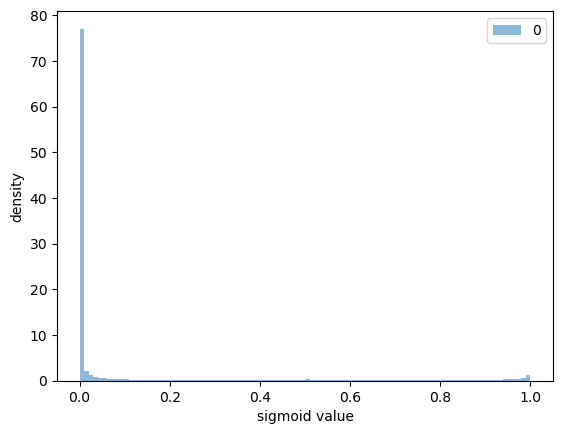

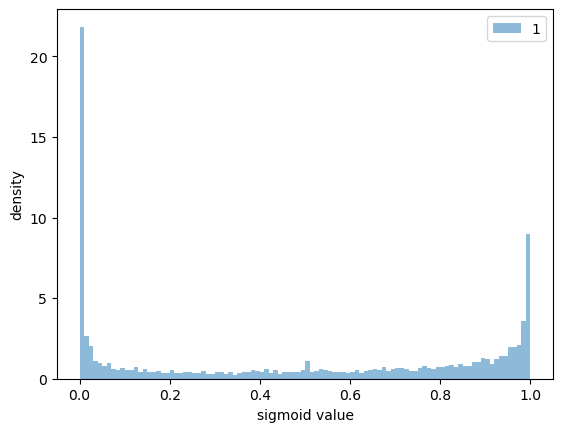

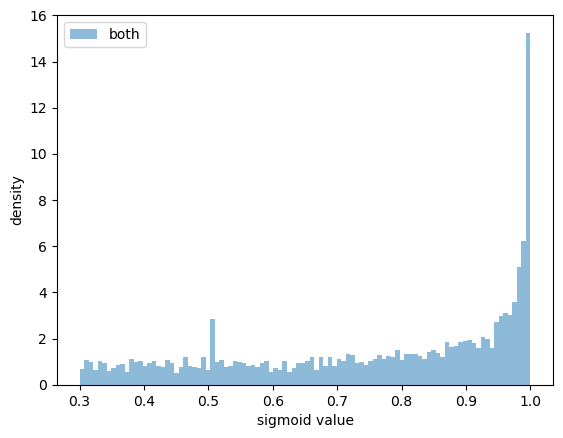

In [84]:
def show_logits_confusion_density():
    model.eval()
    logits = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for data in validation_loader:
            data = data.to(device)
            logits.append(torch.sigmoid(model(data)).squeeze().cpu().numpy())
            y_true.append(data.y.cpu().numpy())
    logits = np.concatenate(logits)
    y_true = np.concatenate(y_true)
    plt.hist(logits[y_true == 0], bins=100, alpha=0.5, label='0', density=True)
    plt.xlabel('sigmoid value')
    plt.ylabel('density')
    plt.legend()
    plt.show()
    plt.hist(logits[y_true == 1], bins=100, alpha=0.5, label='1', density=True)
    plt.xlabel('sigmoid value')
    plt.ylabel('density')
    plt.legend()
    plt.show()
    plt.hist(logits[logits > 0.3], bins=100, alpha=0.5, label='both', density=True)
    plt.xlabel('sigmoid value')
    plt.ylabel('density')
    plt.legend()
    plt.show()
show_logits_confusion_density()

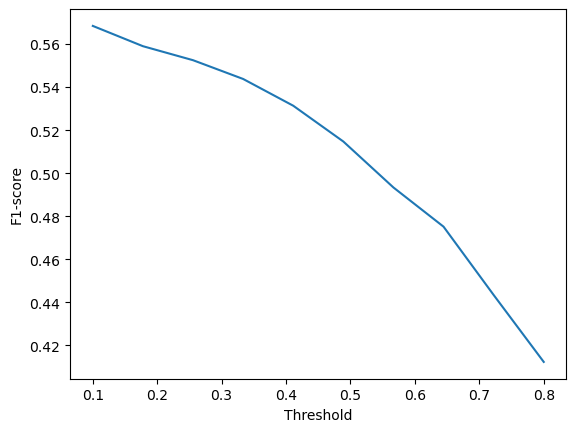

In [85]:
T = np.linspace(0.1,0.8,10)
f1s = []
for t in T:
    model.set_threshold(t)
    f1_valid = aja.f1_score_moyen(model, validation_graphs)
    f1s.append(f1_valid)

plt.plot(T, f1s)
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.show()

In [86]:
# quand on est content on fait une submission !
model.set_threshold(0.75)
aja.make_test_csv_submission(model, test_graphs, 'avec_toutes_les_donnees')